In [1]:
%load_ext autoreload
%autoreload 2

# Classifying Music Note sounds using Few Shot Deep Learning

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import math

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

#### utils

In [4]:
def fft(f):
    Ni = len(f)
    Mi = int(Ni / 2)
    if Mi <= 2:
        return [f[0] + f[1] + f[2] + f[3], 
               f[0] - 1j*f[1] - f[2] + 1j*f[3],
               f[0] - f[1] + f[2] - f[3],
               f[0] + 1j*f[1] - f[2] - 1j*f[3]]
    
    wn = math.cos(2*math.pi/Ni) - 1j*math.sin(2*math.pi/Ni)
    fe = [f[i] for i in range(Ni) if i % 2 == 0]
    fo = [f[i] for i in range(Ni) if i % 2 == 1]
    Fe = fft(fe)
    Fo = fft(fo)
    return [np.around(Fe[i] + (wn**i)*Fo[i], decimals=10) for i in range(Mi)] + [np.around(Fe[i] - (wn**i)*Fo[i], decimals=10) for i in range(Mi)]

def get_audio_data(filename):
    fs = 2**12 # sample rate
    tp = 2 # sampling duration
    N = n = fs*tp # number of samples
    
    # Extract data and sampling rate from file
    recording, fs = librosa.load(filename, sr=fs, duration=tp, mono=True)

    n = len(recording)        
    tp = int(n / fs)

    if tp < 2:
        pad_width = N - recording.shape[0]
        recording = np.pad(recording, pad_width=((0, pad_width),), mode='constant')

        n = len(recording)
        tp = int(n / fs)

    N = fs*tp # number of samples
    x = [np.round(float(recording[i]), 10) for i in range(n)] # input sequence
    return x, tp, n

def get_frequency_amplitude(x, tp, N):
    _X = fft(x) # discrete Fourier transform
    X = [np.round(Xi/N, 10) for Xi in _X] # frequency spectrum
    X_amp = [np.absolute(Xi) for Xi in X] # amplitude spectrum

    M = int(N/2)
    ti = [i*tp/N for i in range(N)]
    fi = [i/tp for i in range(M)]
    X_amp = np.array(X_amp[:M])*2
    
    return ti, fi, X_amp

def extract_features(filepath):
    # try:
    audio_features = get_audio_data(filepath)
    if not audio_features:
        return

    x, tp, N = audio_features
    ti, fi, X_amp = get_frequency_amplitude(x, tp, N)
    return X_amp
#     return fi, X_amp
    
    # except Exception as e:
    #     print("Error encountered while parsing file: ", file_name, e)
    #     return None 
    
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=3) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    pad_width = 256 - mfccs.shape[1]
    
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')     
    return mfccs
    

#### Load Preprocessed data 

In [8]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
DATA_DIR = os.path.join("data", "guitar_sample")

# feature list
features = []

# Iterate through each sound file and extract the features 
for folder in tqdm(os.listdir(DATA_DIR)):
    class_label = folder
    
    if class_label.startswith("0"):
        continue
        
    for file in os.listdir(os.path.join(DATA_DIR, folder)):
        file_name = os.path.join(os.path.join(DATA_DIR, folder, file))
        
        data = extract_features(file_name)
        if data is None:
            continue
        
        data = np.array(data)
        data = np.expand_dims(data, axis=-1)
        features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 


Finished feature extraction from  118  files


In [9]:
# featuresdf.feature = featuresdf.feature.apply(lambda xx: xx.reshape((4096, 2)))
featuresdf.feature.iloc[0].shape

(40, 256, 1)

In [10]:
featuresdf.head()

,feature,class_label
0,"[[[-403.97342], [-427.74152], [-478.33362], [-...",1A
1,"[[[-449.60074], [-470.32797], [-528.5974], [-5...",1A
2,"[[[-374.77917], [-398.41254], [-462.8929], [-4...",1A
3,"[[[-400.76926], [-423.18558], [-481.08386], [-...",1A
4,"[[[-391.5319], [-416.02634], [-477.748], [-511...",1A


In [15]:
from itertools import combinations
from math import factorial

def number_of_combinations(n, r):
    return int(factorial(n) / (factorial(n - r) * factorial(r)))

def prepare_data_pair(X, y, labels):
    data = [[], []]
    data_labels = [[], []]
    data_output = []
    
    for label in labels:
        label = f"1{label}"
        semilabel = f"0{label}"

        indices = np.array(list(range(len(y))))
        similar_indices = indices[y == label]
        if len(similar_indices) < 2:
            continue
            
        train_half_size = number_of_combinations(len(similar_indices), 2)

        semisimilar_indices = indices[y == semilabel][:train_half_size]

        dissimilar_indices = indices[(y != label) & (y != semilabel)]
        np.random.shuffle(dissimilar_indices)

        dissimilar_indices = dissimilar_indices[:train_half_size - len(semisimilar_indices)]
        dissimilar_indices = np.concatenate([semisimilar_indices, dissimilar_indices])

        np.random.shuffle(dissimilar_indices)
        
        counter = 0
        it = iter(dissimilar_indices)

        for i, j in combinations(similar_indices, 2):
            if counter >= len(dissimilar_indices):
                break
                
            counter += 1
            z = next(it)
#             for sim_index, li in enumerate([[i, j], [z, i]]):
            for sim_index, li in enumerate([[z, i], [i, j]]):
                data_output.append(float(sim_index))
                for index, value in enumerate(li):
                    data[index].append(X[value])
                    data_labels[index].append(y[value])
                    
            
        print(y[i], y[j], y[z])
    
    data = np.array(data)
    data_labels = np.array(data_labels)
    data_output = np.array(data_output)
    return data, data_output, data_labels

In [16]:
os.listdir(DATA_DIR)

['0A', '0B', '0D', '0EH', '0EL', '0G', '1A', '1B', '1D', '1EH', '1EL', '1G']

In [17]:
# split the dataset 
from sklearn.model_selection import train_test_split 

# Convert features and corresponding classification labels into numpy arrays
input_data = np.array(featuresdf.feature.tolist())
output_labels = np.array(featuresdf.class_label.tolist())

from sklearn.model_selection import StratifiedShuffleSplit

# split train and test data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=100)
for train_index, test_index in sss.split(input_data, output_label):
    x_train, x_test = input_data[train_index], input_data[test_index]
    y_train_label, y_test_label = output_label[train_index], output_label[test_index]
    
# labels
labels = ["EH", "D", "A", "B", "G", "EL"]

# prepare data set pairs
x_train_pair, y_train_pair, x_train_label_pair = prepare_data_pair(x_train, y_train, labels)

1EH 1EH 1B
1D 1D 1B
1A 1A 1B
1B 1B 1EL
1G 1G 1B
1EL 1EL 1G


In [18]:
x_train.shape, y_train.shape

((94, 40, 256, 1), (94,))

In [19]:
x_test.shape, y_test.shape

((24, 40, 256, 1), (24,))

In [20]:
x_train_pair.shape, y_train_pair.shape

((2, 940, 40, 256, 1), (940,))

In [21]:
for i in range(13):
    print(y_train_pair[i], x_train_label_pair[:, i])

0.0 ['1EL' '1EH']
1.0 ['1EH' '1EH']
0.0 ['1B' '1EH']
1.0 ['1EH' '1EH']
0.0 ['1EL' '1EH']
1.0 ['1EH' '1EH']
0.0 ['1D' '1EH']
1.0 ['1EH' '1EH']
0.0 ['1B' '1EH']
1.0 ['1EH' '1EH']
0.0 ['1D' '1EH']
1.0 ['1EH' '1EH']
0.0 ['1A' '1EH']


### Convolutional Neural Network (CNN) model architecture 

In [58]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Lambda, LayerNormalization, Layer
from tensorflow.keras.layers import BatchNormalization as LayerNormalization, GlobalAveragePooling2D
# from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Conv2D as Conv1D, MaxPooling2D as MaxPooling1D
K.clear_session()

def build_base_network(input_shape):
    model = Sequential()
    
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(LayerNormalization(axis=2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    
    model.add(Conv1D(32, kernel_size=5, activation='relu'))
    model.add(LayerNormalization(axis=2))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Dropout(0.1))
    
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(LayerNormalization(axis=2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
# #     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))

#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))

#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
    
#     model.add(Conv1D(32, kernel_size=3, activation='relu'))
#     model.add(LayerNormalization(axis=-1))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
    
    model.add(Flatten())
    
#     model.add(Dense(1024))
#     model.add(LayerNormalization(axis=-1))
#     model.add(Dropout(0.25))
    
    model.add(Dense(512))
    model.add(LayerNormalization(axis=-1))
    model.add(Dropout(0.15))
    
    model.add(Dense(256))
#     model.add(LayerNormalization(axis=1))
    model.add(Dropout(0.05))
    
    model.add(Dense(128))
    return model

def build_base_network2(input_dim):
    # We only test DenseNet-121 in this script for demo purpose
    
    base_model = tf.keras.applications.DenseNet201(
    # base_network = tf.keras.applications.InceptionV3(
    # base_network = tf.keras.applications.ResNet101(
        include_top=False, weights=None, input_tensor=None, input_shape=input_dim,
        pooling="max", classes=128
    )
    
    # add a global spatial average pooling layer
    x = base_model.output
    
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(128)(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model
    
def distance(emb1, emb2):
    return K.sum(K.square(emb1 - emb2), axis=-1)

def get_euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def get_eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

### Compiling the model 

For compiling our model, we will use the same three parameters as the previous model: 

In [59]:
input_dim = x_train_pair.shape[2:]
base_network = build_base_network(input_dim)

audio_1 = Input(shape=input_dim)
audio_2 = Input(shape=input_dim)

feat_vecs_1 = base_network(audio_1)
feat_vecs_2 = base_network(audio_2)

# # Layer that computes the triplet loss from anchor, positive and negative embedding vectors
difference = Lambda(get_euclidean_distance, output_shape=get_eucl_dist_output_shape)([feat_vecs_1, feat_vecs_2])

# initialize training params
epochs = 8
batch_size = 32

# optimizer = Adam()
optimizer = RMSprop()

# initialize the network
model = Model(inputs=[audio_1, audio_2], outputs=difference)
model.compile(loss=contrastive_loss, optimizer=optimizer)

In [60]:
input_dim

(40, 256, 1)

In [61]:
# Display model architecture summary 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 256, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 40, 256, 1)] 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          514944      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]      

In [62]:
model.layers[2].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 254, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 254, 32)       1016      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 127, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 127, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 123, 32)       25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 123, 32)       492       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 41, 32)         0

### Training 

Here we will train the model. As training a CNN can take a sigificant amount of time, we will start with a low number of epochs and a low batch size. If we can see from the output that the model is converging, we will increase both numbers.  

In [63]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from time import time

checkpointer = ModelCheckpoint(
    filepath='saved_models/weights.best.basic_cnn2.hdf5', 
    verbose=1, 
    save_best_only=True
)

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

start = time()
model.fit(
    [x_train_pair[0], x_train_pair[1]], 
    y_train_pair, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=0.25,
    callbacks=[early_stopper, checkpointer], 
    verbose=1
)

duration = (time() - start)/60
print("Training completed in time: ", duration, "min")

Epoch 1/8
23/23 [==============================] - ETA: 0s - loss: 143.2380
Epoch 00001: val_loss improved from inf to 459.71283, saving model to saved_models\weights.best.basic_cnn2.hdf5
23/23 [==============================] - 36s 2s/step - loss: 143.2380 - val_loss: 459.7128
Epoch 2/8
23/23 [==============================] - ETA: 0s - loss: 63.4564
Epoch 00002: val_loss improved from 459.71283 to 61.22050, saving model to saved_models\weights.best.basic_cnn2.hdf5
23/23 [==============================] - 36s 2s/step - loss: 63.4564 - val_loss: 61.2205
Epoch 3/8
23/23 [==============================] - ETA: 0s - loss: 42.1639
Epoch 00003: val_loss did not improve from 61.22050
23/23 [==============================] - 40s 2s/step - loss: 42.1639 - val_loss: 70.0766
Epoch 4/8
23/23 [==============================] - ETA: 0s - loss: 28.6848
Epoch 00004: val_loss improved from 61.22050 to 43.38447, saving model to saved_models\weights.best.basic_cnn2.hdf5
23/23 [==========================

In [64]:
# load weights
model.load_weights("saved_models/weights.best.basic_cnn2.hdf5")

#### Evaluation

### Best freq treshold

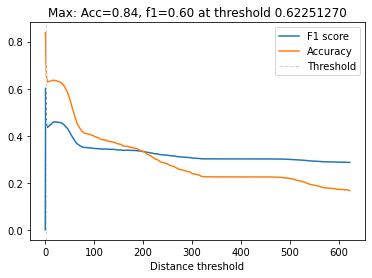

In [65]:
from sklearn.metrics import f1_score, accuracy_score

def get_eval_params(data_input, data_labels):
    pairs = []
    distances = [] # squared L2 distance between pairs
    identical = [] # 1 if same identity, 0 otherwise

    num = len(data_input)
    embedded = model.layers[2].predict(data_input)

    for i in range(num):
        for j in range(num):
            pairs.append([embedded[i], embedded[j]])
            distances.append(distance(embedded[i], embedded[j]))
            identical.append(1 if data_labels[i] == data_labels[j] else 0)
            
    pairs = np.array(pairs)
    distances = np.array(distances)
    identical = np.array(identical)
    
    return pairs, distances, identical, embedded

train_pairs, train_distances, train_identical, train_embedded = get_eval_params(x_train, y_train)
test_pairs, test_distances, test_identical, test_embedded = get_eval_params(x_test, y_test)

min_threshold = min(train_distances)
max_threshold = max(train_distances)
threshold_step = (max_threshold - min_threshold)/1000
thresholds = np.arange(min_threshold, max_threshold, threshold_step)

f1_scores = [f1_score(train_identical, train_distances < t) for t in thresholds]
acc_scores = [accuracy_score(train_identical, train_distances < t) for t in thresholds]

# max f1
opt_idx = np.argmax(f1_scores)
opt_f1 = np.max(f1_scores)

# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]

# Accuracy at maximal F1 score
opt_acc = accuracy_score(train_identical, train_distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Max: Acc={opt_acc:.2f}, f1={opt_f1:.2f} at threshold {opt_tau:.8f}');
plt.xlabel('Distance threshold')
plt.legend();

In [66]:
train_distances.shape, train_pairs.shape, train_identical.shape

((8836,), (8836, 2, 128), (8836,))

In [67]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

le.classes_

array(['1A', '1B', '1D', '1EH', '1EL', '1G'], dtype='<U3')

In [92]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
clf = make_pipeline(SVC(kernel="rbf", gamma='auto'))

xx_train, yy_train = train_distances.reshape(-1, 1), train_identical
xx_test, yy_test = test_distances.reshape(-1, 1), test_identical

# xx_train, yy_train = train_embedded, y_train_le
# xx_test, yy_test = test_embedded, y_test_le

clf.fit(xx_train, yy_train)
clf.score(xx_train, yy_train)

0.9022181982797646

In [93]:
xx_train.shape, yy_train.shape

((8836, 1), (8836,))

In [94]:
# plt.scatter(xx_train, yy_train, c=yy_train)

In [95]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(xx_test)
confusion_matrix(yy_test, y_pred)

array([[460,   8],
       [ 44,  64]], dtype=int64)

In [96]:
np.unique(yy_test), np.unique(y_pred)

(array([0, 1]), array([0, 1]))

In [97]:
from sklearn.metrics import classification_report

print(classification_report(yy_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       468
           1       0.89      0.59      0.71       108

    accuracy                           0.91       576
   macro avg       0.90      0.79      0.83       576
weighted avg       0.91      0.91      0.90       576



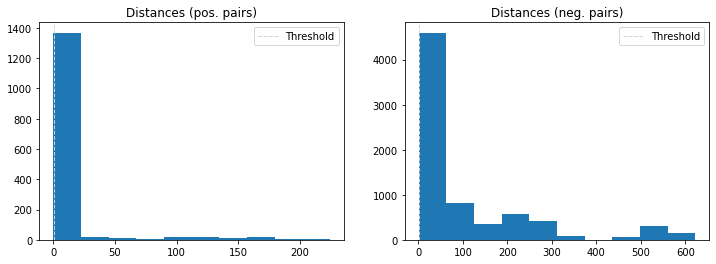

In [98]:
dist_pos = train_distances[train_identical == 1]
dist_neg = train_distances[train_identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

### Testing Evaluation

In [100]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

prediction = test_distances < opt_tau
print("accuracy =", accuracy_score(test_identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(test_identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(test_identical, prediction))

accuracy = 0.8472222222222222

classification_report
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       468
           1       0.60      0.54      0.57       108

    accuracy                           0.85       576
   macro avg       0.75      0.73      0.74       576
weighted avg       0.84      0.85      0.84       576


confusion matrix
[[430  38]
 [ 50  58]]


### Testing (new data) Evaluation

In [101]:
sample_label = "A"
sample_filepath = os.path.join("data", "sampleA.wav")

sample_vector = extract_features(sample_filepath)
sample_vector = np.expand_dims(np.expand_dims(sample_vector, axis=-1), axis=0)

sample_embedded = model.layers[2].predict(sample_vector)
le.inverse_transform(clf.predict(sample_embedded))

ValueError: X.shape[1] = 128 should be equal to 1, the number of features at training time

In [84]:
x_test_sample = []
y_test_sample = []

sample_dirs = ["EH", "D", "A", "B", "G", "EL"]
# sample_dirs = ["A"]

for label in tqdm(sample_dirs):
    print(label, end=", ")
    labeldir= os.path.join("data", "old_guitar_sample", label)

    for filename in (os.listdir(labeldir)):
        anchor_filepath = os.path.join("data", "old_guitar_sample", label, filename)
        
        anchor_file_vector = extract_features(anchor_filepath)
        anchor_file_vector = np.expand_dims(anchor_file_vector, axis=-1)
        x_test_sample.append(anchor_file_vector)
        y_test_sample.append(label)

print()
x_test_sample = np.array(x_test_sample)
y_test_sample = np.array(y_test_sample)

print(x_test_sample.shape)

EH, D, A, B, G, EL, 

(58, 40, 256, 1)


In [85]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise
prediction = []

num = len(x_test_sample)
print(x_test_sample.shape)
embedded = model.layers[2].predict(x_test_sample)

for i in range(num):
    for j in range(num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if y_test_sample[i] == y_test_sample[j] else 0)
        prediction.append(1 if distances[-1] < opt_tau else 0)
        
distances = np.array(distances)
identical = np.array(identical)
prediction = np.array(prediction)

print("accuracy =", accuracy_score(identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(identical, prediction))

(58, 40, 256, 1)
accuracy = 0.786563614744352

classification_report
              precision    recall  f1-score   support

           0       0.92      0.82      0.86      2802
           1       0.41      0.63      0.50       562

    accuracy                           0.79      3364
   macro avg       0.66      0.73      0.68      3364
weighted avg       0.83      0.79      0.80      3364


confusion matrix
[[2290  512]
 [ 206  356]]


### Testing (sample) Evaluation

In [82]:
x_test_sample = []
y_test_sample = []

sample_dirs = ["1EH", "1D", "1A", "1B", "1G", "1EL"]
sample_dirs = ["1A"]

sample_label = "A"
sample_filepath = os.path.join("data", "sampleA.wav")
sample_vector = extract_features(sample_filepath)
sample_vector = np.expand_dims(np.expand_dims(sample_vector, axis=-1), axis=0)
sample_embedded = model.layers[2].predict(sample_vector)

for label in tqdm(sample_dirs):
    print(label, end=", ")
    labeldir= os.path.join(DATA_DIR, label)

    for filename in (os.listdir(labeldir)):
        anchor_filepath = os.path.join(DATA_DIR, label, filename)
        
        anchor_file_vector = extract_features(anchor_filepath)
        anchor_file_vector = np.expand_dims(anchor_file_vector, axis=-1)
        x_test_sample.append(anchor_file_vector)
        y_test_sample.append(1 if label.startswith("1") and label.endswith(sample_label) else 0)

print()
x_test_sample = np.array(x_test_sample)
y_test_sample = np.array(y_test_sample)

print(x_test_sample.shape)

1A, 

(20, 40, 256, 1)


In [83]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

distances = [] # squared L2 distance between pairs
prediction = []

num = len(x_test_sample)
embedded = model.layers[2].predict(x_test_sample)

for i in range(num):
    distances.append(distance(embedded[i], sample_embedded))
    prediction.append(1 if distances[-1] < opt_tau else 0)

identical = y_test_sample
distances = np.array(distances)
prediction = np.array(prediction)

print("accuracy =", accuracy_score(identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(identical, prediction))

accuracy = 0.0

classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00      20.0

    accuracy                           0.00      20.0
   macro avg       0.00      0.00      0.00      20.0
weighted avg       0.00      0.00      0.00      20.0


confusion matrix
[[ 0  0]
 [20  0]]


c:\users\christian\.virtualenvs\guitar_audio_sample_detection\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\christian\.virtualenvs\guitar_audio_sample_detection\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
prediction.shape, identical.shape

In [ ]:
# weights path
# weights_path = os.path.join("C:\\Users\\christian\\Documents\\christian\\work\\python\\guitar_music_note_recognizer\\music_note_recognizer\\static\\music_note_recognizer\\weights", f'{label}_weights.h5')
# weights_path = "saved_models/triplet_128_32.h5"

# load weights
# model.save_weights(weights_path)